In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import pymorphy2
import nltk
import string
import re
import time
import pickle
import operator
import collections
import matplotlib.pyplot as plt
import pylab as pl
import math
import json

from collections import Counter,OrderedDict
from itertools import cycle
from scipy import spatial
from sklearn.externals import joblib
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin,cosine_similarity
from sklearn.preprocessing import scale
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec,KeyedVectors
from nltk import word_tokenize
from nltk.corpus import stopwords

In [2]:
data = pd.read_csv('vk.csv')
data = data.drop(data.columns[[0]], axis=1) 
data.shape

(40117, 2)

In [3]:
# обработка пропущенных значений - удаляем пустые строки из данных
data_upd = data.dropna(axis = 0)
data_upd.shape

(40081, 2)

In [1214]:
# Сохраняем словарь в json-формат 
# json.dump(data_upd.values.tolist(),open("faq.json","w"))  

# Читаем из .json
# data_load= json.load(open("faq.json","rb"))

In [4]:
questions = data_upd['question']

In [5]:
questions.shape

(40081,)

In [5]:
stop_words = nltk.corpus.stopwords.words('russian')
print (stop_words)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [6]:
def text_preproc_corpus(text):
    
    #apply nltk tokenization
    token_text = []
    tokens = [nltk.word_tokenize(sent) for sent in text]
    
    # delete punctuation
    text_punct = []
    s = []
    for sent in tokens:
        for word in sent:
            s.append(re.sub('[a-zA-Z]+|[\d\"\•\)\(\%\.\,\;\:\!\?\_\-\+\/\|\>\<\\\*\@\#\$\^\'\&\=\]]','',word))
#             s.append(re.sub('[\d\"\•\)\(\%\.\,\;\:\!\?\_\+\/\|\>\<\\\*\@\#\$\^\'\&\=\]]','',word))
        text_punct.append(s)
        s = []

    # lemmatize
    lem_text = []
    grams_exclusion = {'NUMB','PREP', 'CONJ', 'PRCL', 'INTJ','NPRO','NNP','NNPS'}
    for sent in text_punct:
        lem_sent =  [morph.parse(word)[0].normal_form for word in sent if morph.parse(word)[0].tag.POS not in grams_exclusion]
        lem_text.append(lem_sent)
          
    # delete stop words 
    stop_words = nltk.corpus.stopwords.words('russian')
    stop_words.extend(['сумма','рубль','опять','почему','снова','каков','здесь','поэтому','както','какнибудь','какиминибудь','какиелибо','какимто','банка','недалеко','никакой','ранее','ктонибудь','часть','всего','давно','тысяча','далее','много','самый','вообще','потом','добрый','деньга','какой','такой','почему','другой','нужно','время','сейчас','теперь','можно','который','как','каждый','назад','очень','что','когда','тогда','более','менее'])
    text_stop = []
    for sent in lem_text:
        t =[w for w in sent if w not in stop_words]
        text_stop.append(t)
        
    # delete words with len(words)<=3
    text_proc = []
    for sent in text_stop:
        t = [word for word in sent if len(word)>4]
        text_proc.append(t)
        
    return text_proc

In [7]:
morph = pymorphy2.MorphAnalyzer()

In [8]:
w2v = pickle.load(open('/Users/maria/ml/Telegram bot/word_vectors.pkl', "rb"))

In [9]:
qst_preproc = text_preproc_corpus(questions)

In [10]:
len(qst_preproc)

40081

In [11]:
qst_preproc_tfidf = []
for sent in qst_preproc:
    t = ' '.join([word for word in sent])
    qst_preproc_tfidf.append(t)
qst_preproc_tfidf[89]

'привет сказать взять ипотека изменить досрочный погашение выплата норма'

In [12]:
len(qst_preproc_tfidf)

40081

In [13]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='word', min_df=10,max_df = 0.8, use_idf=True, sublinear_tf= True)
qst_tfidf = vectorizer.fit_transform(qst_preproc_tfidf)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [40]:
# сохраняем vectorizer
# joblib.dump(vectorizer, 'tfidf.pkl')

# загружаем vectorizer
# vectorizer_loaded= joblib.load(open('tfidf.pkl', "rb"))

In [14]:
qst_tfidf.shape

(40081, 9850)

In [20]:
sorted_tfidf = collections.OrderedDict(sorted(tfidf.items(),key=lambda value: value[1]))
for name,freq in sorted_tfidf.items():
    print (freq,name)

1.751289356532154 карта
2.051298760747686 сбербанк
2.9997251414944968 подсказать
3.0198300629104087 сказать
3.07769664505844 онлайн
3.1930916198784387 вопрос
3.309896824286445 номер
3.3633219909600256 кредит
3.386928237338176 отделение
3.3994932756353062 сбербанк онлайн
3.498217743684011 карта сбербанк
3.5227890044145167 получить
3.5863329953855794 хотеть
3.627942244706278 сделать
3.6439593002154655 делать
3.6538359237113776 кредитный
3.674972300744136 перевод
3.702874257630191 узнать
3.705857108462256 перевести
3.7638945273251796 телефон
3.8339620899418962 мобильный
3.8472073166919167 сегодня
3.865875104291353 снять
3.870707092607815 приходить
3.888477440280841 средство
4.00078468419159 кредитный карта
4.011372128690758 работать
4.019003811622918 платёж
4.050126655543501 написать
4.050653664778359 месяц
4.083338063532938 проблема
4.086065090038863 операция
4.088252078335367 банкомат
4.099259344121146 писать
4.132455078497893 оформить
4.157362244995756 пришлый
4.210973395632333 новый
4

6.836508699915617 карта сегодня
6.836508699915617 мобильный номер
6.836508699915617 обработка
6.836508699915617 овердрафт
6.836508699915617 оплата услуга
6.836508699915617 перевод сбербанк
6.836508699915617 пояснить
6.836508699915617 пятница
6.836508699915617 рассмотреть
6.836508699915617 удалить
6.845092443607009 карта получать
6.845092443607009 мастер
6.845092443607009 налог
6.845092443607009 переехать
6.845092443607009 проводить
6.853750506350123 арестовать
6.853750506350123 карта списать
6.853750506350123 отправитель
6.853750506350123 процедура
6.853750506350123 узнавать
6.862484186318878 карта нужный
6.862484186318878 перевод денежный средство
6.862484186318878 проведение
6.862484186318878 управлять
6.862484186318878 шаблон
6.871294816001033 карта готовый
6.871294816001033 поручитель
6.871294816001033 удобно
6.880183763418279 анкета
6.880183763418279 добавить
6.880183763418279 карта карта сбербанк
6.880183763418279 карта мобильный
6.880183763418279 карта новый
6.880183763418279 ли

7.573330943978225 екатеринбург
7.573330943978225 забыть пароль
7.573330943978225 заказать дебетовый
7.573330943978225 заказать карта индивидуальный
7.573330943978225 заранее благодарный
7.573330943978225 зарплатный клиент
7.573330943978225 зачисление карта
7.573330943978225 изменить номер
7.573330943978225 иметься карта
7.573330943978225 какнибыть
7.573330943978225 карта отправить
7.573330943978225 карта регион
7.573330943978225 кредит наличный
7.573330943978225 кредит одобрить
7.573330943978225 меньший
7.573330943978225 местный отделение
7.573330943978225 непосредственно
7.573330943978225 нести
7.573330943978225 обмануть
7.573330943978225 общаться
7.573330943978225 операция временно
7.573330943978225 оплачивать карта
7.573330943978225 осуществить перевод
7.573330943978225 позволять
7.573330943978225 потребовать
7.573330943978225 предупреждать
7.573330943978225 предусмотреть
7.573330943978225 приостановить
7.573330943978225 прислать делать
7.573330943978225 пришлый сбербанк
7.573330943

7.935120988583727 сказать написать
7.935120988583727 смочь пользоваться
7.935120988583727 снять отделение
7.935120988583727 согласный
7.935120988583727 страница сбербанк
7.935120988583727 телефон подключить
7.935120988583727 тобыть
7.935120988583727 уплата
7.935120988583727 ходить отделение
7.935120988583727 хотеть перевести карта
7.935120988583727 цифра карта
7.935120988583727 человек карта
7.935120988583727 чужой карта
7.961096474986988 администрация
7.961096474986988 банкнот
7.961096474986988 безобразие
7.961096474986988 безопасно
7.961096474986988 большой неделя
7.961096474986988 взять кредитный
7.961096474986988 вопрос ответить
7.961096474986988 вопрос узнать
7.961096474986988 восстанавливать
7.961096474986988 вставлять
7.961096474986988 выдать новый
7.961096474986988 говориться
7.961096474986988 гражданство
7.961096474986988 донецк
7.961096474986988 жилищный
7.961096474986988 забыть карта
7.961096474986988 задерживать
7.961096474986988 задолженность кредит
7.961096474986988 защит

8.302845768709044 дозвониться отделение
8.302845768709044 должный сделать
8.302845768709044 дорога
8.302845768709044 дочерний
8.302845768709044 евгений
8.302845768709044 живой
8.302845768709044 заведовать
8.302845768709044 завершение
8.302845768709044 законодательство
8.302845768709044 закрыть кредитный
8.302845768709044 замечательный
8.302845768709044 заплатить кредит
8.302845768709044 заработок
8.302845768709044 здраствовать вопрос
8.302845768709044 значиться
8.302845768709044 идентификатор пароль
8.302845768709044 извиняться
8.302845768709044 иметь доступ
8.302845768709044 иностранный гражданин
8.302845768709044 история хороший
8.302845768709044 календарный
8.302845768709044 карта заказывать
8.302845768709044 карта иметься
8.302845768709044 карта использовать
8.302845768709044 карта клиент сбербанк
8.302845768709044 карта написать заявление
8.302845768709044 карта остаток
8.302845768709044 карта открывать
8.302845768709044 карта ошибка
8.302845768709044 карта перевести карта
8.30284

8.420628804365428 сниматься комиссия
8.420628804365428 снять вклад
8.420628804365428 совершать операция
8.420628804365428 списываться карта
8.420628804365428 сразу заблокировать
8.420628804365428 средство банковский
8.420628804365428 средство банкомат
8.420628804365428 товар интернет
8.420628804365428 трудно
8.420628804365428 тысруб
8.420628804365428 удостоверение личность
8.420628804365428 хотеть взять потребительский
8.420628804365428 хотеть поинтересоваться
8.420628804365428 хотеть поменять
8.420628804365428 челябинский
8.420628804365428 чехия
8.420628804365428 шесть
8.420628804365428 южный
8.463188418784224 альфабанк
8.463188418784224 аутентификация
8.463188418784224 банкомат сбербанк карта
8.463188418784224 бпссбербанк
8.463188418784224 быстрый платёж
8.463188418784224 вводить правильно
8.463188418784224 вернуть денежный
8.463188418784224 вернуть денежный средство
8.463188418784224 взлом
8.463188418784224 взять ипотечный
8.463188418784224 внести наличный
8.463188418784224 возможны

8.654243655546933 выпустить новый
8.654243655546933 вырасти
8.654243655546933 вычесть
8.654243655546933 гасить кредит
8.654243655546933 глючить
8.654243655546933 господдержка
8.654243655546933 грубый
8.654243655546933 данный номер
8.654243655546933 двойной списание
8.654243655546933 действие закончиться
8.654243655546933 действующий кредит
8.654243655546933 денежка карта
8.654243655546933 денсредство
8.654243655546933 деревня
8.654243655546933 деталь
8.654243655546933 дневный
8.654243655546933 добавиться
8.654243655546933 доверенность получение
8.654243655546933 договор указать
8.654243655546933 документ паспорт
8.654243655546933 должный приходить
8.654243655546933 досрочный погашение ипотека
8.654243655546933 забить
8.654243655546933 заботиться
8.654243655546933 забыть пароль карта
8.654243655546933 заказать выписка
8.654243655546933 занимать перевод
8.654243655546933 запрет
8.654243655546933 застрять
8.654243655546933 заявка молодёжный
8.654243655546933 заявка перевыпуск карта
8.6542

8.826093912473592 отказываться принимать
8.826093912473592 открытый москва
8.826093912473592 открыть сберкнижка
8.826093912473592 отображаться номер
8.826093912473592 отписаться
8.826093912473592 отправлять карта
8.826093912473592 отчётный
8.826093912473592 оформить карта молодёжный
8.826093912473592 оформление дебетовый карта
8.826093912473592 пароль личный кабинет
8.826093912473592 пароль пароль
8.826093912473592 пароль регистрация
8.826093912473592 пенсия сберкнижка
8.826093912473592 перевести книжка
8.826093912473592 перевод золотой
8.826093912473592 перевод осуществить
8.826093912473592 перевод осуществляться
8.826093912473592 перевод человек
8.826093912473592 переводить сбербанк онлайн
8.826093912473592 перевыпустить новый
8.826093912473592 перенос
8.826093912473592 пересчёт
8.826093912473592 перечислить номер
8.826093912473592 писать вопрос
8.826093912473592 писать заявление перевыпуск
8.826093912473592 плата овердрафт
8.826093912473592 платёж мобильный
8.826093912473592 платёж 

8.959625305098115 перевыпуститься
8.959625305098115 перечесление
8.959625305098115 перечисление зарплата
8.959625305098115 период кредитный карта
8.959625305098115 писать письмо
8.959625305098115 платёж сказать
8.959625305098115 победитель акция
8.959625305098115 повестись
8.959625305098115 повторить операция
8.959625305098115 погасить карта
8.959625305098115 погасить кредитный
8.959625305098115 подать жалоба
8.959625305098115 подать заявка оформление
8.959625305098115 подойти отделение
8.959625305098115 подсказать взять ипотека
8.959625305098115 подсказать знать
8.959625305098115 подсказать комиссия снятие
8.959625305098115 подсказать пополнить
8.959625305098115 подсказать узнать реквизит
8.959625305098115 подсказать услуга
8.959625305098115 подтверждение телефон
8.959625305098115 позиция
8.959625305098115 пойти сбербанк
8.959625305098115 покупка валюта
8.959625305098115 покупка товар
8.959625305098115 положить наличный
8.959625305098115 получать детский
8.959625305098115 получаться с

9.033733277251837 операция приходить
9.033733277251837 операция проводить
9.033733277251837 операция сделать
9.033733277251837 оплата произвести
9.033733277251837 оплата телефон
9.033733277251837 оплатить детский
9.033733277251837 оплатить кредитный
9.033733277251837 оповещение карта
9.033733277251837 определённый отделение
9.033733277251837 оставить жалоба
9.033733277251837 ответ делать
9.033733277251837 ответ номер
9.033733277251837 ответ обратиться
9.033733277251837 отделение выпустить карта
9.033733277251837 отделение отправить
9.033733277251837 отделение оформлять карта
9.033733277251837 отделение прийти
9.033733277251837 отделение сбербанк заранее
9.033733277251837 отделение сбербанк оформлять
9.033733277251837 отделение сказать карта
9.033733277251837 отключение услуга
9.033733277251837 отключить оповещение
9.033733277251837 открытый вклад пополнять
9.033733277251837 отображение
9.033733277251837 отредактировать
9.033733277251837 отсчёт
9.033733277251837 официально трудоустроить

9.113775984925374 оплата банковский карта
9.113775984925374 оплата годовой
9.113775984925374 оплата годовой обслуживание
9.113775984925374 оплата заказ
9.113775984925374 оплата мобильный связь
9.113775984925374 оплата сбербанконлайн
9.113775984925374 оплатить сбербанконлайн
9.113775984925374 оплатить сегодня
9.113775984925374 оплачивать сбербанк онлайн
9.113775984925374 оптимальный
9.113775984925374 оренбургский
9.113775984925374 основа
9.113775984925374 особенность
9.113775984925374 особый режим
9.113775984925374 остаток денежный
9.113775984925374 остаток денежный средство
9.113775984925374 отвезти
9.113775984925374 ответ сказать
9.113775984925374 ответить знать
9.113775984925374 ответить проблема
9.113775984925374 отделение выдать карта
9.113775984925374 отделение дозвониться
9.113775984925374 отделение поменять
9.113775984925374 отделение попросить
9.113775984925374 отделение смочь
9.113775984925374 отказ операция
9.113775984925374 отказ проведение операция
9.113775984925374 отказ с

9.200787361915003 онлайн канал доставка
9.200787361915003 онлайн невозможно
9.200787361915003 онлайн новый
9.200787361915003 онлайн номер телефон
9.200787361915003 онлайн отключить
9.200787361915003 онлайн открыть вклад
9.200787361915003 онлайн подать заявка
9.200787361915003 онлайн подключать
9.200787361915003 онлайн позвонить
9.200787361915003 онлайн положить
9.200787361915003 онлайн прислать
9.200787361915003 онлайн сберкнижка
9.200787361915003 онлайн сразу
9.200787361915003 оператор номер
9.200787361915003 оператор служба забота
9.200787361915003 операция повторить
9.200787361915003 операция производиться
9.200787361915003 операция пройти успешно
9.200787361915003 операция совершить
9.200787361915003 операция успешно
9.200787361915003 оплата госпошлина
9.200787361915003 оплата интернет магазин
9.200787361915003 оплата ипотека
9.200787361915003 оплата покупка интернет
9.200787361915003 оплата сотовый
9.200787361915003 оплатить касса
9.200787361915003 оплатить квартплата
9.2007873619

In [15]:
 def featurize_w2v(model, text, vsize=300):
    f = np.zeros((len(text), vsize))
    for i,s in enumerate(text):
        #count = 0.
        for w in s:
            try:
                vec = model[w].reshape((1, vsize))*tfidf[w]
                #count +=1.
            except KeyError:
                continue
            f[i,:] = f[i,:] + vec
        if len(s) !=0: #count != 0:
            f[i,:] = f[i,:] / len(s)
    return f

In [16]:
qst_w2v = featurize_w2v(w2v, qst_preproc) 
print (qst_w2v.shape)

(40081, 300)


In [17]:
# The preprocessing.scale() algorithm puts your data on one scale. This is helpful with largely sparse datasets. 
# qst_w2v = scale(qst_w2v)

In [921]:
# questions_w2v[0]

In [1023]:
# В случае текстовых данных,после преобразования текста в разреженную матрицу можно применить сингулярное разложение(SVD).
# Количество компонент сингулярного разложения обеспечивает хороший результат в случае признаков, 
# полученных в результате преобразования с помощью TfidfVectorizer.

# svd = TruncatedSVD(n_components=2000, random_state=1)
# qst_svd = svd.fit_transform(qst_tfidf)

In [1024]:
# explained_variance = svd.explained_variance_ratio_.sum()
# explained_variance   

### K-Means clustering

In [ ]:
# K-means minimizes within-cluster variance. 

#### Определяем opt количество кластеров

In [40]:
%%time
# inertia or within-cluster sum-of-squares - метрика базируется на измерении внутрикластерного расстояния между объектами 
# The optimal variant will be the number of clusters where inertia is stabilized.
# Эвристика - выбирают то число кластеров, начиная с которого описанный функционал падает "уже не так быстро". 

inertia = []
N_cl = range(1000,5000,500)
for i in N_cl:
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state=1, max_iter=300, n_init=10, tol = 0.0001)
    inert = np.sqrt(kmeans.fit(qst_w2v).inertia_)
    inertia.append(inert)

inertia = np.asmatrix(inertia) 

CPU times: user 7h 17min 16s, sys: 3h 2min 51s, total: 10h 20min 8s
Wall time: 16h 48min 45s


In [41]:
inertia

matrix([[2384.7551934 , 2285.2974994 , 2207.52960372, 2144.3406736 ,
         2086.17302146, 2036.9517854 , 1990.32198401, 1946.549904  ]])

Text(0.5,1,'Dependency: Inertia VS Number of Clusters')

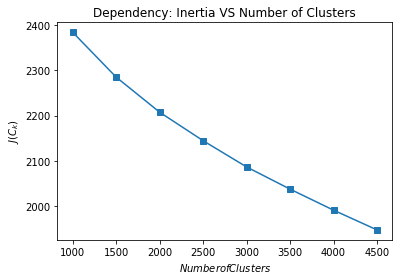

In [43]:
# N_cl = range(1000,5000,500)
pl.plot(N_cl, inertia.T, marker='s')
pl.xlabel('Number of Clusters')
pl.ylabel('WCSS')
pl.title('Dependency: Inertia VS Number of Clusters')

In [ ]:
# https://github.com/scikit-learn/scikit-learn/issues/6156 - про параметры inertia_ и score

In [47]:
%%time
# Elbow curve -  метрика базируется на измерении внутрикластерного расстояния между объектами
# The elbow curve shows the percentage of variance explained by the number of clusters.
# When graph levels stabilized it means that adding of more clusters do not explain much more of the variance
# in our relevant variable; in this case the number of clusters will be optimal.

N = range(200,2000,200)
scores = []
for i in N:
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state=1, max_iter=300, n_init=10, tol = 0.0001)
    score = kmeans.fit(qst_w2v).score(qst_w2v)
    print ("-----Score" +' ' + str(i) + ' ' + 'is executed!--------')
    scores.append(score)
scores = np.asmatrix(scores)

Score 200 is executed!
Score 400 is executed!
Score 600 is executed!
Score 800 is executed!
Score 1000 is executed!
Score 1200 is executed!
Score 1400 is executed!
Score 1600 is executed!
Score 1800 is executed!
CPU times: user 3h 4min 21s, sys: 32min 50s, total: 3h 37min 12s
Wall time: 6h 4min 4s


In [48]:
scores

matrix([[-7423787.045509  , -6686371.3897236 , -6240565.34509238,
         -5927547.84462396, -5687057.33246318, -5485010.63684543,
         -5299231.12794297, -5151255.83777629, -5002730.0683756 ]])

Text(0.5,1,'Elbow Curve')

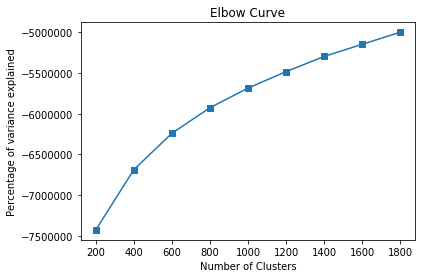

In [49]:
# N = range(200,2000,200)
pl.plot(N,scores.T, marker='s')
pl.xlabel('Number of Clusters')
pl.ylabel('Percentage of variance explained')
pl.title('Elbow Curve')

#### Выполняем кластеризацию

In [24]:
kmeans = KMeans(n_clusters = 200, init='k-means++', random_state=1, max_iter=300, n_init=10, tol = 0.0001)

In [25]:
%%time
kmeans.fit_predict(qst_w2v)

CPU times: user 4min 59s, sys: 38.6 s, total: 5min 38s
Wall time: 4min 42s


array([ 90,  32, 115, ...,  94, 124, 184], dtype=int32)

In [1039]:
kmeans.labels_

array([ 90,  32, 115, ...,  94, 124, 184], dtype=int32)

In [4]:
# сохраняем обученную модель
# joblib.dump(kmeans, 'km_model.pkl')

# загружаем модель
# km = joblib.load(open('km_model.pkl', "rb"))

In [26]:
km.labels_

array([ 90,  32, 115, ...,  94, 124, 184], dtype=int32)

In [27]:
labels = km.labels_
centroids = km.cluster_centers_
clusters = len(km.cluster_centers_)

In [1046]:
# Counter(labels).items()

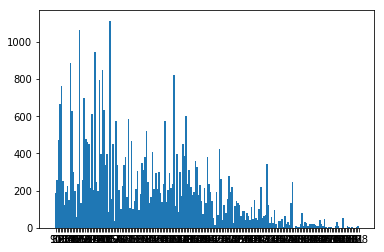

In [28]:
label, values = zip(*Counter(labels).items())

indexes = np.arange(len(label))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

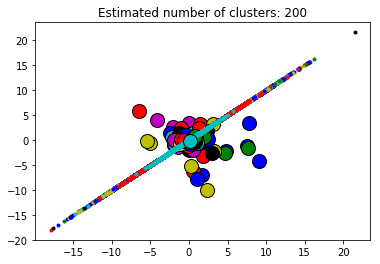

CPU times: user 2min 21s, sys: 13.1 s, total: 2min 34s
Wall time: 2min 41s


In [29]:
%%time
# график полученных кластеров, построенный по их центрам
plt.figure(1)
plt.clf()
 
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(0,clusters), colors):
    my_members = labels == k
    cluster_center = centroids[k]
    plt.plot(qst_w2v[my_members], qst_w2v[my_members], col + '.')
    plt.plot(cluster_center[0], cluster_center[1],'o', markerfacecolor=col,markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' %clusters)
plt.show()

#### Присваиваем текстовые имена кластерами 

In [30]:
# Способ 1 - с использованием центров кластеров  
# Проблема -  слова выводятся в алфавитном порядке, в не по частоте убывания - делала проверку правильности данной 
# сортировки, оказалось, что данные слова не обладают максимальной частотой применительно к каждому центру кластера. 
# не понятно почему? данный метод широко применяется на просторах интернета как один из способов определения текстовых имен кластерам

order_centroids = km.cluster_centers_.argsort()[:,::-1]
terms = vectorizer.get_feature_names()
s = []
clst_names = []
n = []
for i in range(0,clusters):
    for ind in order_centroids[i, :5]:
        d=terms[ind]
        s.append(d)
#         for x in s:
#             n += x.split(' ')
#          words_count = Counter(words).most_common()[:n]
#       clst_names.append(words_count)
    clst_names.append(' | '.join (x for x in s))
    s = []
    n=[] 
    print("Top cluster tags %d: " %i + clst_names[i])

Top cluster tags 0: айфон | баланс кредитный | банковский выписка | банкомат забрать | банкомат комиссия
Top cluster tags 1: амазона | берет | аккредитовать сбербанк | банкомат писать | белгородский область
Top cluster tags 2: банкомат отделение | бонусный | большой пользоваться | барнаул | банковский карта сбербанк
Top cluster tags 3: администратор | арестовать зарплатный | билет | банковский приложение | абхазия
Top cluster tags 4: банковский карта | арестовывать | большой карта | банковский | адрес банкомат
Top cluster tags 5: большой карта | автоматический | брянск | активно | адрес отделение
Top cluster tags 6: акция молодая | бесплатный услуга | архив | архангельский область | анкета получение
Top cluster tags 7: большинство | безопасный | баланс мобильный | безналичный расчёт | америка
Top cluster tags 8: благодарить | большой ответ | активно пользоваться | беспокоиться | актуальный
Top cluster tags 9: большой карта | брянск | акция сбербанк | альфа | автоматический
Top cluster 

In [32]:
# Способ 2 -  вариант, на котором я в итоге остановилась - это вывод ТОП самых частых слов среди документов, 
# относящихся к определенному кластеру

In [33]:
def top_n_words(questions, n):
    words = []
    for el in questions:
        words += el.split(' ')
    words_count = Counter(words).most_common()[:n]
    w = []    
    for word in words_count:
        w.append(word[0])
    return w

In [34]:
cl_qst = []*questions.shape[0]
for i in range(questions.shape[0]):
    cl_qst += [(km.labels_[i],i)]

In [37]:
clst_names_2 = []
cluster_words = [[]] * clusters
for i in range(0, clusters):
    cluster_words[i] = []

for i in range(0,len(cl_qst)):
    cur_cluster = cl_qst[i][0]
    cluster_words[cur_cluster] += [qst_preproc_tfidf[i]]
    
for i in range(0, clusters):
    clst_names_2 += [top_n_words(cluster_words[i], 6)]
    
for i in range(0, clusters):
    print ('Cluster' + str(i) + ': '+ str(clst_names_2[i]) +'\n===========')

Cluster0: ['приходить', 'подтверждение', 'сбербанк', 'онлайн', 'карта', 'пароль']
Cluster1: ['карта', 'сбербанк', 'платёж', 'кредитный', 'кредит', 'месяц']
Cluster2: ['карта', 'моментум', 'сбербанк', 'сказать', 'оформить', 'получить']
Cluster3: ['карта', 'сбербанк', 'сказать', 'отделение', 'вопрос', 'сотрудник']
Cluster4: ['мошенник', 'обман', 'жулик']
Cluster5: ['мошенница', 'осторожный', 'остерегаться', 'добавиться', 'пароль', 'бдительный']
Cluster6: ['карта', 'перевод', 'перевести', 'сбербанк', 'онлайн', 'переводить']
Cluster7: ['карта', 'сбербанк', 'подсказать', 'перевод', 'страна', 'россия']
Cluster8: ['отделение', 'сбербанк', 'область', 'карта', 'подсказать', 'город']
Cluster9: ['мошенница']
Cluster10: ['кредит', 'платить', 'карта', 'брать', 'сбербанк', 'заплатить']
Cluster11: ['орлов', 'мошенница', 'марин', 'мошенник', 'ирина', 'сбербанк']
Cluster12: ['', 'карта', 'сбербанк', 'подсказать', 'узнать', 'платёж']
Cluster13: ['пинкод', 'карта', 'ввести', 'забыть', 'делать', 'восстано

#### Создаем массивы

In [38]:
# создаем словарь, где ключом являются номера кластеров, а элементами - векторизованные представления документов,принадлежащие им

arr_matrix = qst_w2v
matrix_id = []
for i in range(0, arr_matrix.shape[0]):
    matrix_id += [(arr_matrix[i],i)]
    
vect_qst = [[]]*clusters
for key, cluster_id in zip(matrix_id, km.labels_):
    if len(vect_qst[cluster_id]) == 0:
        vect_qst[cluster_id] = []
    arr = key[0].tolist()
    vect_qst[cluster_id] += [(arr, key[1])]

In [39]:
# Сохраняем словарь в json-формат 
# json.dump(vect_qst,open("vect_qst.json","w"))  

# Читаем из .json
# vect_qst_loaded = json.load(open("vect_qst.json","rb"))

### Находим ответы на вопросы

#### Формат ответа: 
#### result1 = [список 5 ближайших троек вида: {вопрос, ответ, confidence}, 
#### result2 = [список названий/эталонных вопросов 5 ближайших кластеров с некоторым confidence]

In [1087]:
# находим ближайший вопрос для нового обращения
text =['здравствуйте! подскажите, как оформить ипотеку онлайн?']
vec1 = featurize_w2v(w2v,text_preproc_corpus(text))
dist = []

for i in range(len(vect_qst_loaded)):
    for j in range(len(vect_qst_loaded[i])):
        similarity = 1 - spatial.distance.cosine(vec1, vect_qst_loaded[i][j][0])
        dist += [(similarity, vect_qst_loaded[i][j][1], i)]

dist.sort(reverse=True)
dist[:5]

[(0.7726718890289346, 28230, 86),
 (0.7204561198042503, 9396, 86),
 (0.716046785791185, 18715, 86),
 (0.7094786334635376, 21921, 86),
 (0.6922598815781308, 13475, 86)]

In [1200]:
result1 = []

for i in range(0, 5):
    doc_idx = dist[i][1]
    result1 += [(data_upd['question'][doc_idx], data_upd['answer'][doc_idx], dist[i][0])]

for x in result1:
    print ('Вопрос:\n' + str(x[0]) + "\n" + 'Ответ:\n' + str(x[1]) + "\n" + 'Confidence: ' + str(x[2]*100) + "\n===========")   

Вопрос:
писала неоднократно, 30.06.2015г., 24.08.2015г., 30.10.2015г., 09.11.2015г., и обошла все головные офисы, последнee обращение n 000912-2016-010770, думала поправят к 20.02. график неконкретный постоянно с июня 2015 года, из-за ошибки операциониста. при внесение мною досрочного платежа, она нажала на кнопку реструктуризация, признав свою ошибку, c тех пор я слышу у вас что-то с графиком, а я к графику не имею никакого отношения. я вовремя пополняю счет. а в этот раз по графику 20.02.16г. не списали даже проценты по пользованию кредитом, а долг насчитают ежедневно, только теперь не звонят, что у меня долг, хотя деньги лежат на счете. что мне делать? я не желаю платить за ошибки банка, и не являюсь должником. ответь и разобраться никто не хочет. с уважением !!!
Ответ:
 по имеющей у нас информации, ваше обращение ещё находится в работе, проводится экспертиза. рекомендуем вам дождаться результатов рассмотрения.
Confidence: 77.26718890289345
Вопрос:
всех приветствую. подскажите, у ме

In [1162]:
# находим ближайший кластер для нового обращения
dist_clst = []

for i in range(len(centroids)):
        similarity = 1 - spatial.distance.cosine(vec1, centroids[i])
        dist_clst += [(similarity,  i)]
dist_clst.sort(reverse=True)
dist_clst[:5]

[(0.6310982266388849, 86),
 (0.37292858835054765, 34),
 (0.32365107724545406, 82),
 (0.31922817271293913, 176),
 (0.3112079805347766, 174)]

In [1262]:
result2 = []

for i in range(0, 5):
    clst_id = dist_clst[i][1]
    result2 += [(clst_id, reference_qst[clst_id][0], reference_qst[clst_id][1], dist_clst[i][0])]

for x in result2:
    print ('Имя кластера: ' + str(x[0]) + '. ' + str(x[1]) + "\n" +'Reference question: ' + str(x[2]) + "\n" + 'Confidence: ' + str(x[3]*100) + "\n===========")

Имя кластера: 86. логин
Reference question: пароль
Confidence: 63.109822663888494
Имя кластера: 34. посмотреть
Reference question: карта
Confidence: 37.292858835054766
Имя кластера: 82. приложение
Reference question: сбербанк
Confidence: 32.3651077245454
Имя кластера: 176. возраст
Reference question: семья
Confidence: 31.922817271293912
Имя кластера: 174. карта
Reference question: сбербанк
Confidence: 31.12079805347766


#### Находим референсный (эталонный) вопрос для каждого кластера

In [1288]:
# Cпособ 1 - через значения параметра closest  - остановилась на данном варианте
from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, qst_w2v)
ref_qst = []
for i in range(0,clusters):
    ref = [str(closest[i]),questions[closest[i]]]
    ref_qst.append(ref)
    ref = []

# создаем список референсных вопросов и названий кластеров, где ключом является номер кластера    
reference_qst = []
for i in range(len(dist1_sort_top)):
    reference_qst += [(clst_names_2[i], ref_qst[i])]

for i in range(0,clusters):
    print ('Reference question, cluster ID ' + str(i) + ': ' + str(reference_qst[i]) + '\n==========')

Reference question, cluster ID 0: (['приходить', 'подтверждение', 'сбербанк', 'онлайн', 'карта', 'пароль'], ['25039', 'опять не могу вывести с карты деньги в инет. что происходит?'])
Reference question, cluster ID 1: (['карта', 'сбербанк', 'платёж', 'кредитный', 'кредит', 'месяц'], ['5955', ',куда из сбербанка онлайн делась оплата сотового оператора мтс?вместо мтс почему то стоит значок оплаты в фонд подари жизнь.... а как же мне теперь баланс телефона пополнять??'])
Reference question, cluster ID 2: (['карта', 'моментум', 'сбербанк', 'сказать', 'оформить', 'получить'], ['12373', 'подскажите, для перевода средств на карту сбербанка другого лица достаточно только номера карта и тип карты (допустим mastercard standard) кому идет перевод?'])
Reference question, cluster ID 3: (['карта', 'сбербанк', 'сказать', 'отделение', 'вопрос', 'сотрудник'], ['19980', 'https://vk.com/id317532573 https://vk.com/im?peers=317532573&amp;sel=201158353 мошенники'])
Reference question, cluster ID 4: (['мошенн

In [1239]:
# Cпособ 2 - через косинусное расстояние от центра кластера до документа из базы - есть частичное пересечение 
# с базой эталонных вопросов из Способа 1

dist1 = []
for i in range(len(vect_qst_loaded)):
    for j in range(len(vect_qst_loaded[i])):
        similarity = 1 - spatial.distance.cosine(centroids[i],vect_qst_loaded[i][j][0])
        dist1 += [(similarity, vect_qst[i][j][1], i)]

dist1_sort = sorted(dist1, key=lambda x: (x[2], -x[0]))

curr_cluster = -1
dist1_sort_top = []

for i in range(len(dist1_sort)):
     if dist1_sort[i][2] != curr_cluster:
            dist1_sort_top += [dist1_sort[i]]
            curr_cluster = dist1_sort[i][2]

# создаем список референсных вопросов и названий кластеров, где ключом является номер кластера    
reference_qst_2 = []
for i in range(len(dist1_sort_top)):
    reference_qst_2 += [(clst_names_2[i],data['question'][dist1_sort_top[i][1]])]
for i in range(0,clusters):
    print ('Reference question, cluster ID ' + str(i) + ': ' + str(reference_qst_2[i]) + '\n==========')

Reference question, cluster ID 0: (['приходить', 'подтверждение', 'сбербанк', 'онлайн', 'карта', 'пароль'], 'здрасьте, у меня беда случилась. потеряла дебетоваю карту momentum, что нужно для ее восстановления и сколько это займет времени и денег? :) спасибо за ответ')
Reference question, cluster ID 1: (['карта', 'сбербанк', 'платёж', 'кредитный', 'кредит', 'месяц'], 'у меня в банкомате высветилось-узнать свое персональное предложение? что это значит, картой пользуюсь более года')
Reference question, cluster ID 2: (['карта', 'моментум', 'сбербанк', 'сказать', 'оформить', 'получить'], 'подскажите пожалуйста, делал покупку на ebay, но с доставкой не сложилось и делал возврат денег через paypal, деньги не пришли но они теперь находятся в "собственных средствах", я их снять не могу, что делать?')
Reference question, cluster ID 3: (['карта', 'сбербанк', 'сказать', 'отделение', 'вопрос', 'сотрудник'], 'обслуживаюсь в двух филиалах. вышла замуж, сменила фамилию,пришла в банк одного филиала и п

In [1290]:
# загружаем в json базу эталонных(референсных) вопросов для каждого кластера
# json.dump(reference_qst,open("reference_qst.json","w"))  

# Читаем из .json
# reference_qst_loaded = json.load(open("reference_qst.json" ,"rb"))